<a href="https://colab.research.google.com/github/CodeManJay/Movielens-Embedding-Recommendation-System/blob/main/MovieLens_Recommender_System_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all the necessary or Important libraries for this project.





In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf
import pandas as pd
import numpy as np

In [ ]:
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error 
from sklearn.neighbors import NearestNeighbors  
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [ ]:
from keras.models import Model
%matplotlib inline

In [ ]:
from urllib.request import urlretrieve
import collections
import zipfile



# Retrieve dataset and URL, extract

In [ ]:
print("Downloading dataset...")
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print(zip_ref.read('ml-100k/u.info'))

b'943 users\n1682 items\n100000 ratings\n'


# Analyse Dataset.

In [ ]:
info = pd.read_csv("/content/ml-100k/u.info", sep=" ", header=None)
info.columns=['Counts', 'Type']
info

,Counts,Type
0,943,users
1,1682,items
2,100000,ratings


In [ ]:
genre = pd.read_csv('/content/ml-100k/u.genre', sep="|", encoding='latin-1', header=None)
genre.drop(genre.columns[1], axis=1, inplace=True)
genre.columns = ['Genres']
genre_list = list(genre['Genres'])
genre_list

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

# Remove delimiters,etc

In [ ]:
data = pd.read_csv('/content/ml-100k/u.data', sep="\t", header=None)
data.columns = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
data.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
item = pd.read_csv('/content/ml-100k/u.item', sep="|", encoding='latin-1', header=None)
item.columns = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 
                'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
item.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
#Load the User data
user = pd.read_csv('/content/ml-100k/u.user', sep="|", encoding='latin-1', header=None)
user.columns = ['user id', 'age', 'gender', 'occupation', 'zip code']
user.head()

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


Specify the columns for users and ratings

In [ ]:
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

In [ ]:
#different genre columns
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
#different movie columns, with genres appended
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols

movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

In [ ]:
movies.columns

Index(['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
       'genre_unknown', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [ ]:
# ids must start from index 0, split release date, change ratings to float, etc
users["user_id"]=users["user_id"].apply(lambda x: int(x-1))

In [ ]:
ratings["user_id"]=ratings["user_id"].apply(lambda x: int(x-1))
ratings["movie_id"]=ratings["movie_id"].apply(lambda x: int(x-1))
ratings["rating"]=ratings["rating"].apply(lambda x: float(x))

In [ ]:
movies["movie_id"]=movies["movie_id"].apply(lambda x: int(x-1))
movies["year"]=movies['release_date'].apply(lambda x: str(x).split('-')[-1])

# Merge all these columns  for one final dataframe


In [ ]:
movielens=ratings.merge(movies, on='movie_id').merge(users, on='user_id')

In [ ]:
movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1997,49,M,writer,55105
1,195,256,2.0,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1997,49,M,writer,55105
2,195,110,4.0,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1996,49,M,writer,55105
3,195,24,4.0,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1996,49,M,writer,55105
4,195,381,4.0,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1994,49,M,writer,55105


In [ ]:
movielens.columns

Index(['user_id', 'movie_id', 'rating', 'unix_timestamp', 'title',
       'release_date', 'video_release_date', 'imdb_url', 'genre_unknown',
       'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'year',
       'age', 'sex', 'occupation', 'zip_code'],
      dtype='object')

In [ ]:
min_rating=min(movielens["rating"])
max_rating=max(movielens["rating"])

# Split into training and test sets

In [ ]:
train, test = train_test_split(movielens, test_size=0.1)

In [ ]:
ROW_COUNT=train.shape[0]

In [ ]:
#specifying embedding size, and assign all non unique user ids and movie ids
EMBEDDING_SIZE=10
NUM_USERS=movielens['user_id'].nunique()
NUM_MOVIES=movielens['movie_id'].nunique()

In [ ]:
train.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code
50917,915,236,3.0,880843419,Jerry Maguire (1996),13-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Jerry%20Magui...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1996,27,M,engineer,N2L5N
7852,770,172,4.0,880659894,"Princess Bride, The (1987)",01-Jan-1987,NaN,http://us.imdb.com/M/title-exact?Princess%20Br...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1987,26,M,student,15232
23788,268,237,5.0,891448850,Raising Arizona (1987),01-Jan-1987,NaN,http://us.imdb.com/M/title-exact?Raising%20Ari...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1987,31,F,librarian,43201
21043,404,1383,1.0,885549746,Squeeze (1996),13-Jun-1997,NaN,http://us.imdb.com/M/title-exact?Squeeze%20%28...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1997,22,F,healthcare,10019
49590,626,401,3.0,879530866,Ghost (1990),01-Jan-1990,NaN,http://us.imdb.com/M/title-exact?Ghost%20(1990),0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1990,24,M,engineer,08034


In [ ]:
UNIQUE_MOVIE_IDS = movielens['movie_id'].unique()

# Create the Neural Network.

Define the Embedding Layers, etc and apply dropout feature to reduce overfitting.

In [ ]:

def EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):
    movie_input=keras.Input(shape=(1,), name='movie_id')

  # Add Embedding Layer
    movie_emb=layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_embedding_layer')(movie_input)
    movie_vec=layers.Flatten(name='FlattenMovie')(movie_emb)

  #Model Input for movies
    movie_model=keras.Model(inputs=movie_input, outputs=movie_vec)
    
    user_input=keras.Input(shape=(1,), name='user_id')

    user_emb=layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_embedding_layer')(user_input)
    user_vec=layers.Flatten(name='FlattenUser')(user_emb)

  #Model input froM user

    user_model=keras.Model(inputs=user_input, outputs=user_vec)
  
  #Take the dot Product 
    merged=layers.Dot(name = 'dot_product_layer', normalize = True, axes = 2)([movie_emb, user_emb])
    merged_dropout=layers.Dropout(0.2)(merged)
 
    dense_1=layers.Dense(70,name='Layer_1')(merged)
    dropout_1=layers.Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2=layers.Dense(50,name='Layer_2')(dropout_1)
    dropout_2=layers.Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3=keras.layers.Dense(20,name='Layer_3')(dropout_2)
    dropout_3=keras.layers.Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4=keras.layers.Dense(10,name='Layer_4', activation='relu')(dropout_3)

    #output layer
    result=layers.Dense(1, name='result', activation="relu") (dense_4)

    adam=keras.optimizers.Adam(lr=0.001)
    model=keras.Model([movie_input, user_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error',metrics=["accuracy"])
    return model, movie_model, user_model

In [ ]:
model, movie_model, user_model = EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT)

In [ ]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('besttest.h5', save_best_only=True)]

history = model.fit([train.movie_id, train.user_id],train.rating, batch_size=100,
                              epochs =50, validation_data = ([test.movie_id, test.user_id],test.rating),
                              verbose = 1, 
                              callbacks = callbacks)

Epoch 1/50
900/900 [==============================] - 3s 3ms/step - loss: 1.3460 - accuracy: 0.0558 - val_loss: 0.9308 - val_accuracy: 0.0607
Epoch 2/50
900/900 [==============================] - 2s 2ms/step - loss: 0.9599 - accuracy: 0.0608 - val_loss: 0.9412 - val_accuracy: 0.0607
Epoch 3/50
900/900 [==============================] - 2s 2ms/step - loss: 0.9351 - accuracy: 0.0609 - val_loss: 0.9232 - val_accuracy: 0.0607
Epoch 4/50
900/900 [==============================] - 2s 2ms/step - loss: 0.9216 - accuracy: 0.0612 - val_loss: 0.9166 - val_accuracy: 0.0607
Epoch 5/50
900/900 [==============================] - 2s 2ms/step - loss: 0.9067 - accuracy: 0.0612 - val_loss: 0.9046 - val_accuracy: 0.0607
Epoch 6/50
900/900 [==============================] - 2s 2ms/step - loss: 0.8789 - accuracy: 0.0611 - val_loss: 0.8089 - val_accuracy: 0.0607
Epoch 7/50
900/900 [==============================] - 2s 2ms/step - loss: 0.7242 - accuracy: 0.0616 - val_loss: 0.7798 - val_accuracy: 0.0607
Epoch 

# View the summary of the model

In [ ]:
#print model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_embedding_layer (Embeddin (None, 1, 10)        16820       movie_id[0][0]                   
__________________________________________________________________________________________________
user_embedding_layer (Embedding (None, 1, 10)        9430        user_id[0][0]                    
____________________________________________________________________________________________

# Detailed model plot

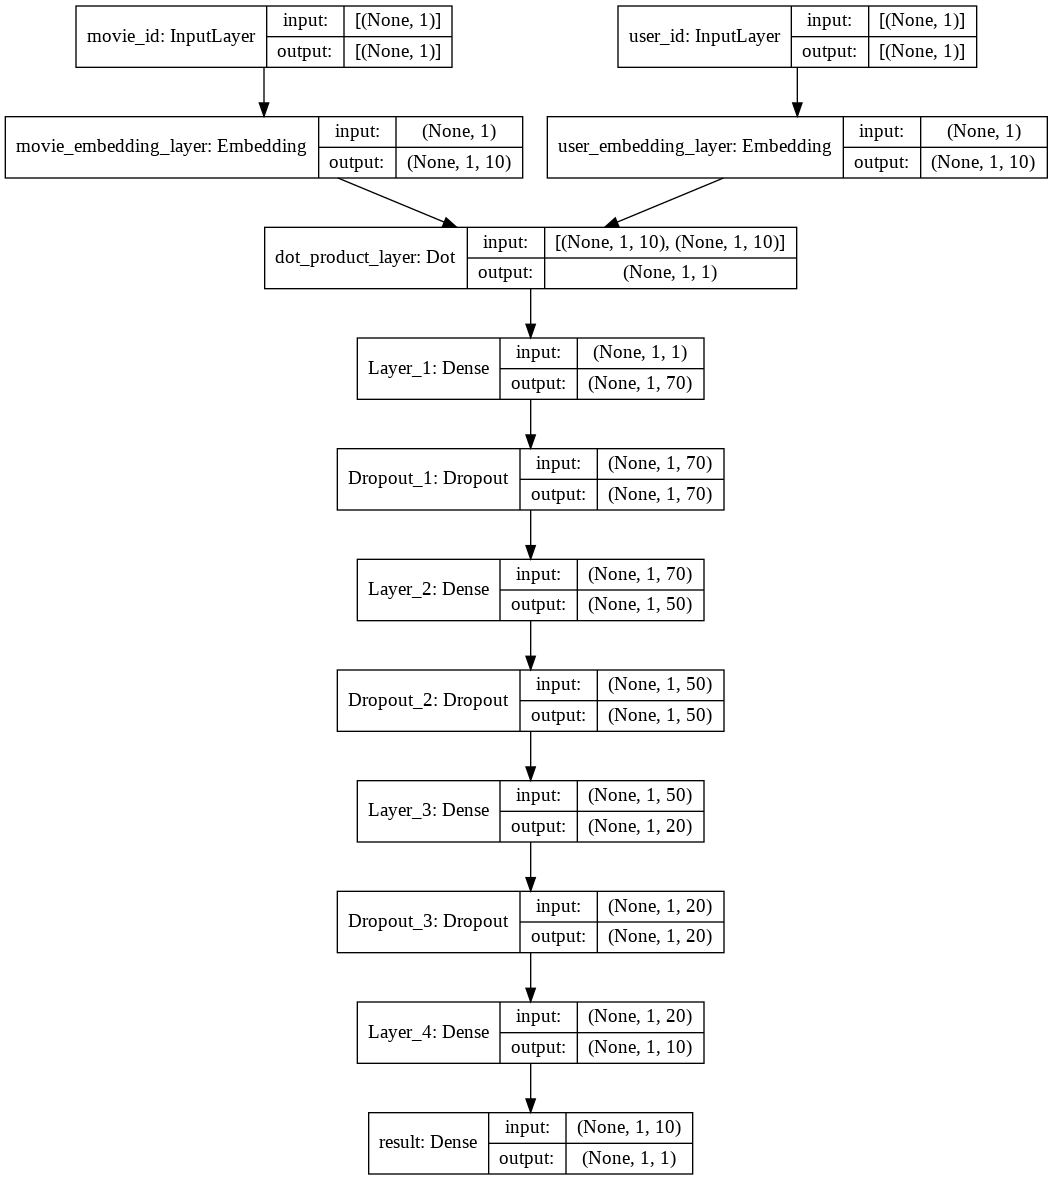

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

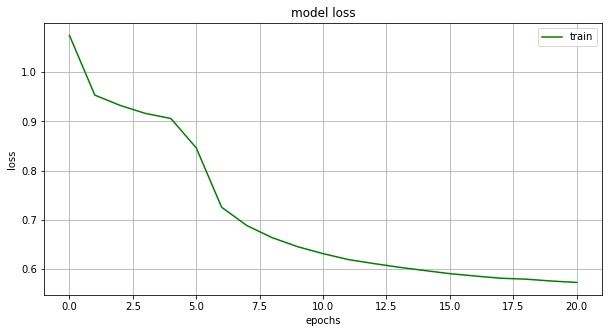

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'], loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
REC_USER_ID = 200
TEST_MOVIE_ID = 123

In [ ]:
MOVIE_EMBEDDINGS_DATABASE = []
EMBEDDING_MAP = collections.defaultdict()

In [ ]:
for _id in UNIQUE_MOVIE_IDS:
    emb = movie_model.predict(np.array([_id]))
    val = list(emb.reshape(1,-1))[0]
    MOVIE_EMBEDDINGS_DATABASE.insert(_id, val)
    EMBEDDING_MAP[_id] = val

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def plot_tsne(model, MOVIE_EMBEDDINGS_DATABASE, size = NUM_MOVIES):
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(MOVIE_EMBEDDINGS_DATABASE[:size])
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    labels = list(range(0,size))
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
    plt.show()

## Plot TSNE Model

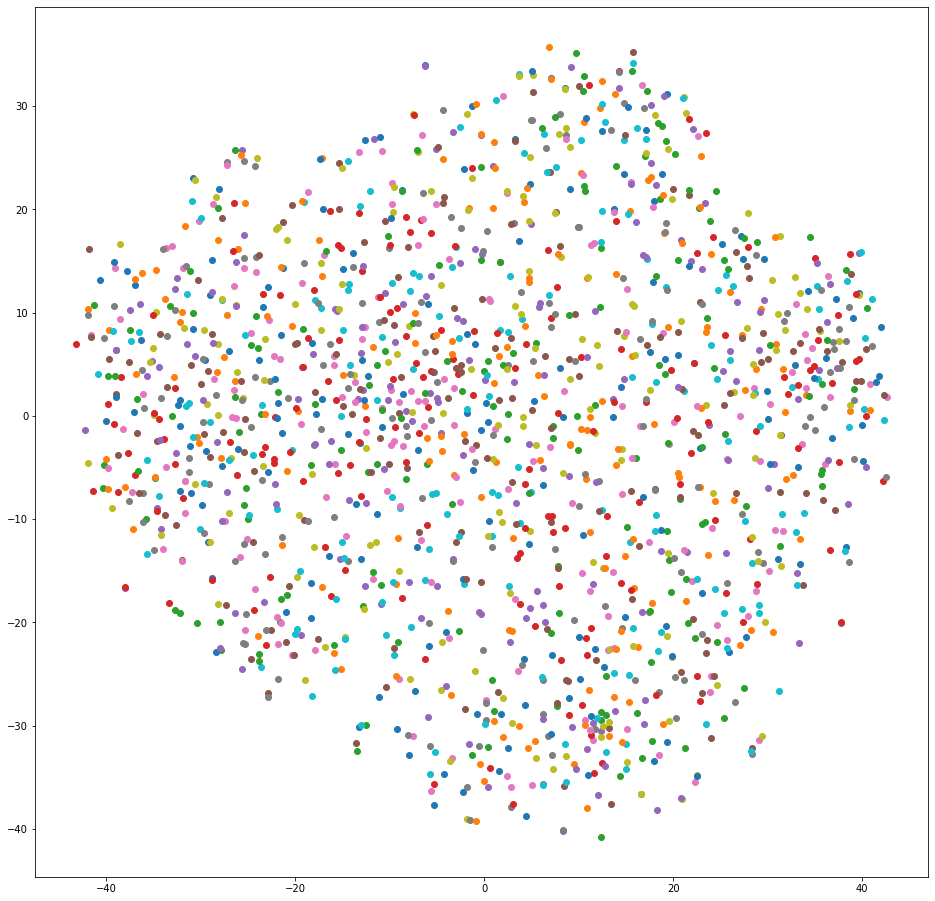

In [ ]:
plot_tsne(model, MOVIE_EMBEDDINGS_DATABASE)

# Show 300 only on the plot

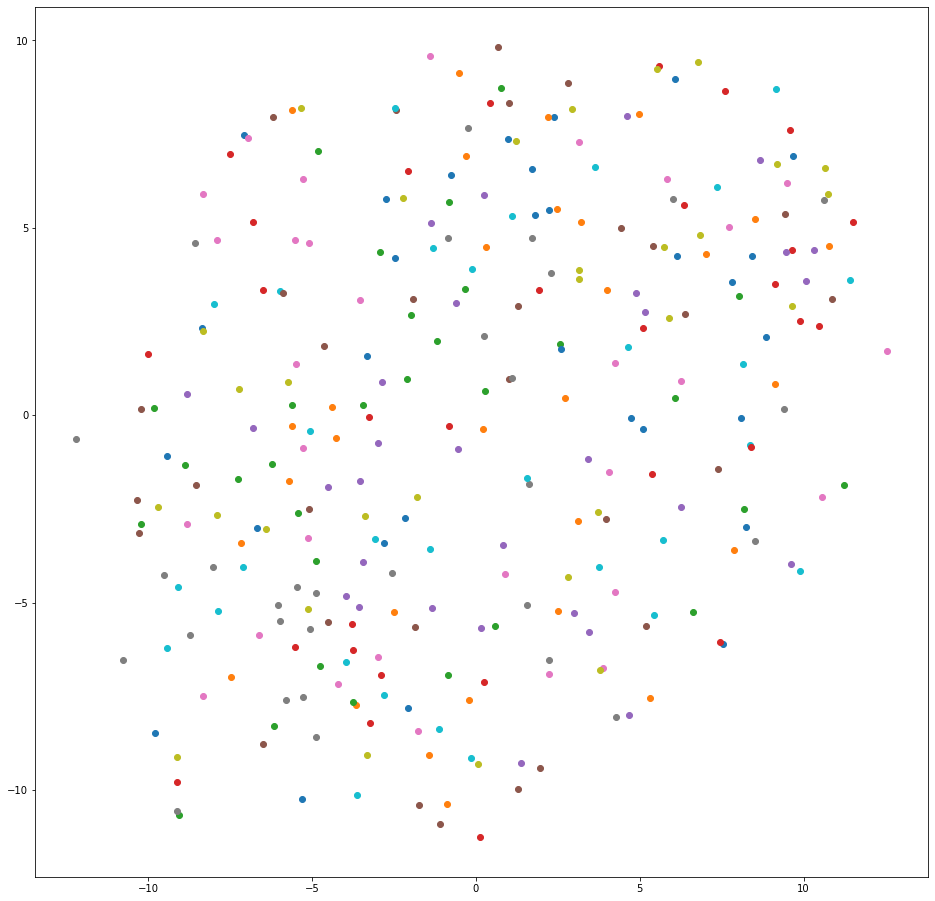

In [ ]:
plot_tsne(model, MOVIE_EMBEDDINGS_DATABASE, 300)

In [ ]:
np.average(movielens.loc[movielens['movie_id'] == 53, 'rating'], axis=0)

3.2403846153846154

In [ ]:
np.average(movielens.loc[movielens['movie_id'] == 66, 'rating'], axis=0)

3.0485436893203883

In [ ]:
knn_train_label = UNIQUE_MOVIE_IDS

# KNN for closest

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(MOVIE_EMBEDDINGS_DATABASE, knn_train_label)

def recommend_movies(embedding):
    distances, indices = clf.kneighbors(embedding.reshape(1, -1),  n_neighbors=10)
    indices = indices.reshape(10,1)
    df_indices = pd.DataFrame(indices, columns = ['movie_id'])
    return df_indices.merge(movies,on='movie_id',how='inner',suffixes=['_u', '_m'])['title']

In [ ]:
REC_USER_ID

200

In [ ]:
REC_USER_ID = 200

In [ ]:
user_embedding = user_model.predict([REC_USER_ID]).reshape(1,-1)[0]

In [ ]:
recommend_movies(user_embedding)

0                                Beyond Rangoon (1995)
1                                    Nightwatch (1997)
2                       Man Without a Face, The (1993)
3                                        Mirage (1995)
4                          Beauty and the Beast (1991)
5                                  Citizen Ruth (1996)
6                                        Angela (1995)
7    Wonderful, Horrible Life of Leni Riefenstahl, ...
8           Secret Adventures of Tom Thumb, The (1993)
9                                         T-Men (1947)
Name: title, dtype: object

In [ ]:
REC_USER_ID=355

In [ ]:
user_embedding = user_model.predict([REC_USER_ID]).reshape(1,-1)[0]
recommend_movies(user_embedding)

0                Good Morning (1971)
1            To Catch a Thief (1955)
2                   Screamers (1995)
3    Ghost and Mrs. Muir, The (1947)
4                      Mother (1996)
5        Perfect Candidate, A (1996)
6               Graduate, The (1967)
7                        Wolf (1994)
8         Tie That Binds, The (1995)
9            City of Industry (1997)
Name: title, dtype: object